<a href="https://colab.research.google.com/github/egecandrsn/dog_breed_classification/blob/main/dog_breed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro
##120 Dog Breed Classification

This code is part of Global AI Hub Akbank Deep Learning Bootcamp.

Data source: [kaggle.com/competitions/dog-breed-identification/data](https://www.kaggle.com/competitions/dog-breed-identification/data)

### 0. Preparing The Data
This section includes the steps of downloading and processing the data.


---



In [1]:
# Libraries for preparing data
import requests
import zipfile
import os
import pandas as pd
from shutil import copyfile
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Kaggle data urls
train_url = "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/7327/861871/upload/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1700770218&Signature=Y889VSxFm9Rs1VvDq7BuP1ijTbLRcZXehgbYlxjSJdsYw%2F3SPCef1C%2BjSwowLphNouZXS28%2FAa9ghGmrvnL9x5L8hdfvMNuotd4pK%2FcZIV9yDdDUH0x0Mpgdw3Vqt5x7vz0rWJxqYoomO%2Fs2PzwdO36zUWIHg2Fhfhna%2FoZuI4OOJuueyukNhJWBX%2FzaTWSF12GRVhRjWH7KQBNrhdsY4vt0tRk6r3qWhIvKNNqbEJAp7LmhUSv7jRWICdkWaynnJvIrBqLuvojvb3wfx%2BYnZPGNVioJgtLtnftR5PzLa5NlV%2FQhVrjVsla%2FTEJQT5SSPb0KcHY3fP0%2BzexK6b1RIA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
labels_url = "https://storage.googleapis.com/kagglesdsdata/competitions/7327/861871/labels.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1700770308&Signature=Hll3dXt%2Bhll18O%2BTiH637Y5i5g7aSXiclhSqyEkOXA6SCJk2L9Vj33JXL%2FtVwJIVv%2B%2FpsM%2FIJnZVh5mLmgu7b25jDRhnqoWDuL%2F2TYnM%2Fwng0asznZ4bAAN%2F16Dkmf2FPsjknyTHgeRjv73xnUnOwVI0obDxajRJTuXCJIcj8IxVbUpmP5e0Skn7LmtqkKTkDxuOJf9HH6dJ%2BOsRfxuYy7fO09KRBAhBHZmwwDNdWx4aL%2F2Uxw%2BBTvUMzMEIxv5cju%2BGwdoZjghUzvPtDMApF3%2FIaAt2rNeDjkb2LRcaG%2F8t%2Bi46o8nSYOR5xF8JAYajt%2F%2BXAI15D3O6ucaG3fsnpw%3D%3D&response-content-disposition=attachment%3B+filename%3Dlabels.csv"

In [3]:
# A fucntion for download zip file and extract it.
def download_and_extract(url, destination):
    response = requests.get(url, stream=True)
    zip_file_path = destination + ".zip"

    with open(zip_file_path, 'wb') as zip_file:
        for chunk in response.iter_content(chunk_size=128):
            zip_file.write(chunk)
    try:
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(destination)
      os.remove(zip_file_path)
    except:
      print("Check url. It's not valid.")

In [4]:
# Download and extract train data
download_and_extract(train_url, "train")

In [5]:
# Open labels.csv
labels_csv = pd.read_csv(labels_url)

In [6]:
# id column matches with train file names
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

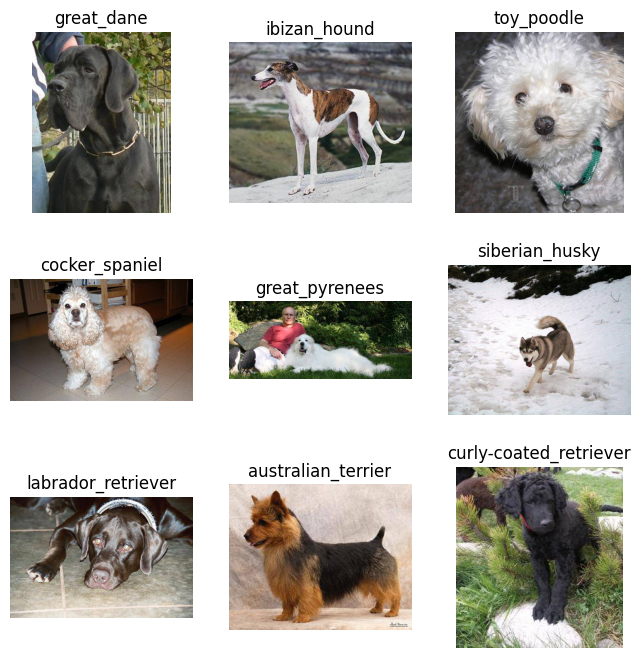

In [8]:
# Let's check data if everthing is correct or not
def display_random_images(directory="train", labels_csv=labels_csv):
    files_in_directory = [file for file in Path(directory).iterdir() if file.is_file()]
    random_samples = random.sample(files_in_directory, k=9)
    file_names = [path.name for path in random_samples]

    plt.figure(figsize=(8, 8))
    for i, file in enumerate(file_names):
        row = labels_csv[labels_csv['id'] == file.split('.')[0]]
        image_path = Path(directory) / file

        plt.subplot(3, 3, i + 1)
        image = Image.open(image_path)
        plt.imshow(image)

        plt.title(row['breed'].values[0])
        plt.axis('off')

    plt.show()

display_random_images()

In [7]:
# Create subdirectories for training data where subdirectories are breed names.
# torchvision ImageFolder needs this format. see: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html
os.makedirs("data", exist_ok=True)
train_dir = os.path.join("data", "train")
os.makedirs(train_dir, exist_ok=True)

for index, row in labels_csv.iterrows():
    img_id = row['id']
    breed_category = row['breed']

    img_filename = f"{img_id}.jpg"
    img_source_path = os.path.join("train", img_filename)
    img_destination_path = os.path.join(train_dir, breed_category, img_filename)

    os.makedirs(os.path.join(train_dir, breed_category), exist_ok=True)
    copyfile(img_source_path, img_destination_path)

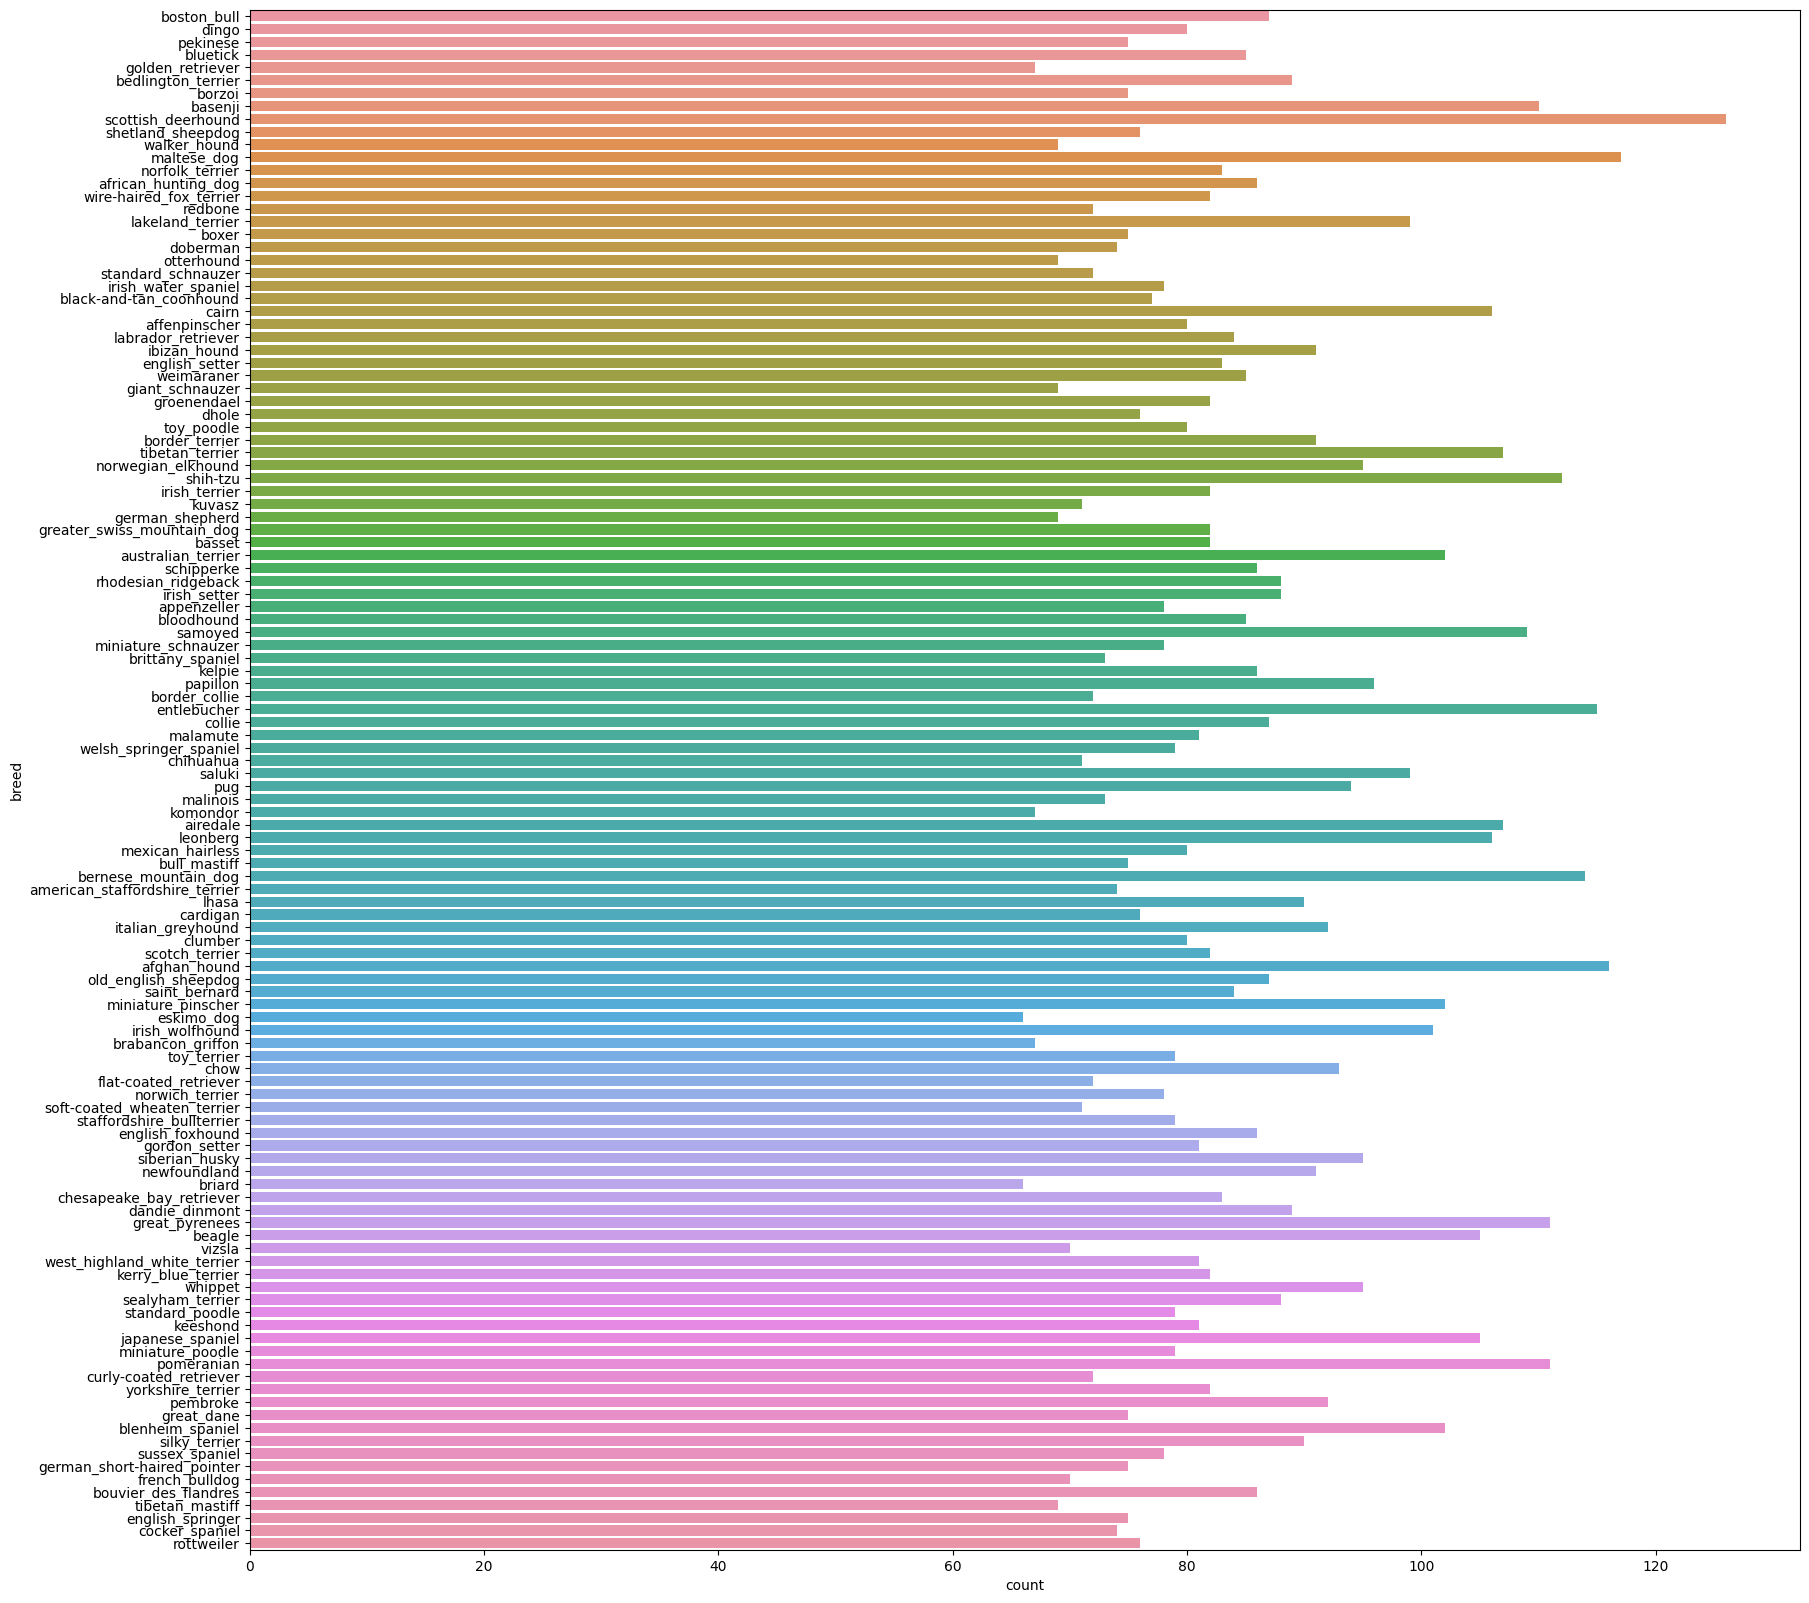

In [9]:
# It's a imbalanced dataset. We need to modified loss function for class imbalance.
import seaborn as sns
plt.figure(figsize=(20,20))
sns.countplot(y="breed",data=labels_csv)
plt.show()

### 1. Loading The Data
This section includes the steps of transforming the data for the model, separating it into training and validation data and loading it into the dataloader object for training in batches.


---



In [10]:
# Libraries for loading data
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader

In [11]:
# Define the transformations for train and validation. We use same transform for both because we are not applying data augmentation.
transform = transforms.Compose([transforms.Resize([224, 224]), transforms.ToTensor()])

# ImageFolder is a handy tool, we can directly use it with dataloader.
full_dataset = datasets.ImageFolder(root=os.path.join("data", "train"), transform=transform)

# torch.utils.data.random_split expect the exact sizes for training and validation sets rather than ratio
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2)

### 2. Create models
This section includes the steps of creating the vgg-16 model from scratch and the resnet101 model using transfer learning. It also includes creating custom class weights for the class imbalance problem.


---



In [12]:
# Libraries for create models
import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
import torchvision.models as models
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [13]:
# To get summary of model
try:
  from torchsummary import summary
except:
  !pip install torchsummary
  from torchsummary import summary

In [14]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Getting labels from train data
labels = torch.tensor([label for _, label in train_dataset], dtype=torch.long)

# Unique classes from the dataset
unique_classes = torch.unique(labels).numpy()

# Calculate class weights using scikit-learn's compute_class_weight
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels.numpy())

# The computed class weights need to be converted to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

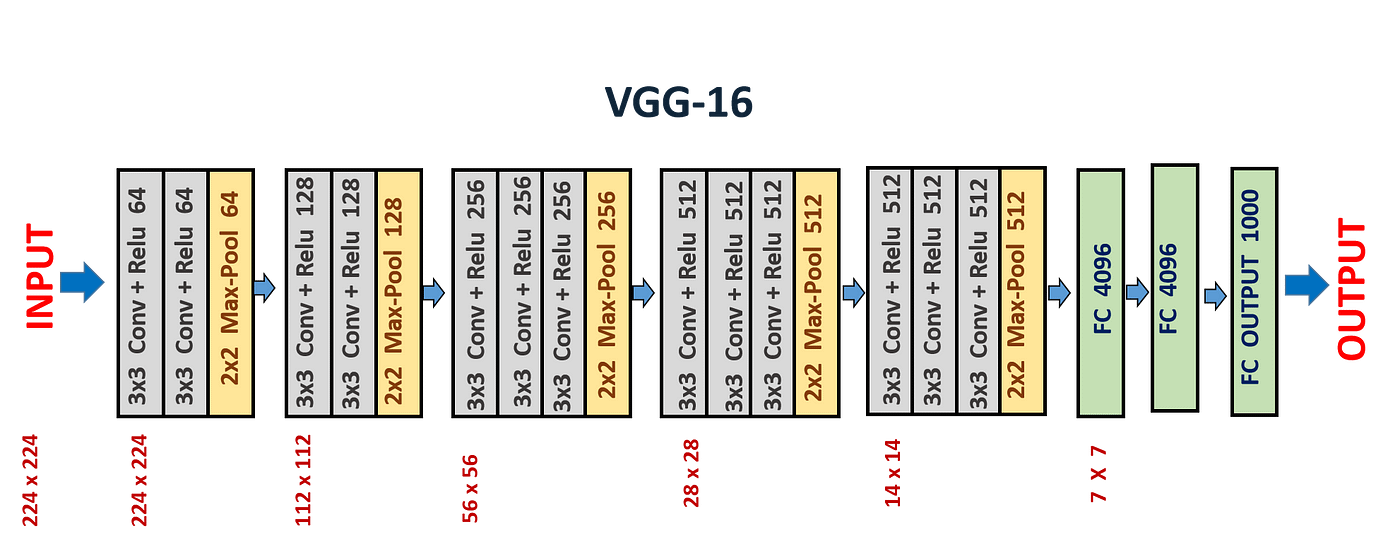

In [16]:
# Implement original VGG-16 model above.
# Just added extra Dropout and Batch Normalization layers according to https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf and https://arxiv.org/pdf/1502.03167.pdf papers.
class VGG16(nn.Module):
  def __init__(self, input_size=3, num_classes=120, hidden_units=64):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(input_size, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.block2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.block3 = nn.Sequential(
        nn.Conv2d(hidden_units*2, hidden_units*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(),
        nn.Conv2d(hidden_units*4, hidden_units*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(),
        nn.Conv2d(hidden_units*4, hidden_units*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.block4 = nn.Sequential(
        nn.Conv2d(hidden_units*4, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.block5 = nn.Sequential(
        nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.Conv2d(hidden_units*8, hidden_units*8, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*8),
        nn.ReLU(),
        nn.MaxPool2d(2,2))

    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(7*7*hidden_units*8, hidden_units*hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units*hidden_units, hidden_units*hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units*hidden_units, num_classes))

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.dense(x)
    return x

In [17]:
# Create the model and summarize
model = VGG16(input_size=3, num_classes=120, hidden_units=32).to(device) # For computational efficiency, i reduced the number of hidden units to 32 from 64
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         MaxPool2d-7         [-1, 32, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          18,496
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
           Conv2d-11         [-1, 64, 112, 112]          36,928
      BatchNorm2d-12         [-1, 64, 112, 112]             128
             ReLU-13         [-1, 64, 112, 112]               0
        MaxPool2d-14           [-1, 64,

In [26]:
# Custom ResNet model with pre-trained convolutional layers and fully connected layers for classification
class ResNet(nn.Module):
    def __init__(self, num_classes=120):
        super().__init__()
        resnet = models.resnet101(pretrained=True)

        # Freeze the parameters of the pre-trained layers
        for param in resnet.parameters():
            param.requires_grad = False

        # Removing the fully connected layers at the end
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Adding custom fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [27]:
# Create resnet model and summarize
resnet = ResNet().to(device)
summary(resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 3. Training models
This section includes Train function to train the model and Plot function to visualize it.

---



In [20]:
# Libraries for training models
import torch
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn

In [21]:
# Define a training function for a PyTorch model, conducting training and validation loops, computing losses and accuracies over specified epochs.
# Returns lists of training and validation losses and accuracies for plotting.
def Train(model, epochs=10, save=False):
  criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
  optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay =1e-4, momentum = 0.9)
  train_losses = []
  train_accuracies = []
  valid_losses = []
  valid_accuracies = []

  for epoch in range(epochs):
    print(f"----------------------------------------------------\nEpoch:{epoch+1}")
    model.train()
    train_loss = 0.0
    total_train = 0
    train_acc = 0

    for image, label in tqdm(train_loader, desc="Training ..."):
      image, label = image.to(device), label.to(device)

      output = model(image)
      loss = criterion(output, label)

      optimizer.zero_grad()

      loss.backward()
      optimizer.step()

      train_loss += loss.item()

      _, predicted = torch.max(output, 1)
      total_train += label.size(0)
      train_acc += (predicted == label).sum().item()

    train_accuracy = 100 * train_acc / total_train
    avg_train_loss = train_loss / len(train_loader)


    model.eval()
    valid_loss = 0.0
    total_valid = 0
    valid_acc = 0
    with torch.no_grad():
      for image, label in tqdm(valid_loader, desc="Validation ..."):
        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        valid_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total_valid += label.size(0)
        valid_acc += (predicted == label).sum().item()

    valid_accuracy = 100 * valid_acc / total_valid
    avg_valid_loss = valid_loss / len(valid_loader)
    print(f"Train Loss: {avg_train_loss:.2f} - Train Acc: {train_accuracy:.2f}% - Validation Loss: {avg_valid_loss:.2f} - Validation Acc: {valid_accuracy:.2f}%")
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)

    # Save model
    if save:
      model_scripted = torch.jit.script(model)
      model_scripted.save('model_scripted.pt')
  return train_losses, train_accuracies, valid_losses, valid_accuracies

In [22]:
# Define a plotting function that takes 4 list as argument
def Plot(train_losses, train_accuracies, valid_losses, valid_accuracies):
  plt.figure(figsize=(12, 4))
  epochs = len(train_losses)
  # Plotting Loss
  plt.subplot(1, 2, 1)
  plt.plot(range(1, epochs + 1), train_losses, label='Train')
  plt.plot(range(1, epochs + 1), valid_losses, label='Validation')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  # Plotting Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
  plt.plot(range(1, epochs + 1), valid_accuracies, label='Validation')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [23]:
# Train the VGG-16 model
train_losses, train_accuracies, valid_losses, valid_accuracies = Train(model, epochs=10)

----------------------------------------------------
Epoch:1


Validation ...: 100%|██████████| 64/64 [00:09<00:00,  6.77it/s]


Train Loss: 4.78 - Train Acc: 1.28% - Validation Loss: 4.67 - Validation Acc: 1.96%
----------------------------------------------------
Epoch:2


Validation ...: 100%|██████████| 64/64 [00:09<00:00,  6.54it/s]


Train Loss: 4.59 - Train Acc: 2.25% - Validation Loss: 4.50 - Validation Acc: 2.54%
----------------------------------------------------
Epoch:3


Validation ...: 100%|██████████| 64/64 [00:08<00:00,  7.39it/s]


Train Loss: 4.44 - Train Acc: 3.14% - Validation Loss: 4.34 - Validation Acc: 3.57%
----------------------------------------------------
Epoch:4


Validation ...: 100%|██████████| 64/64 [00:08<00:00,  7.38it/s]


Train Loss: 4.32 - Train Acc: 3.79% - Validation Loss: 4.35 - Validation Acc: 4.21%
----------------------------------------------------
Epoch:5


Validation ...: 100%|██████████| 64/64 [00:10<00:00,  6.18it/s]


Train Loss: 4.21 - Train Acc: 5.52% - Validation Loss: 4.23 - Validation Acc: 5.18%
----------------------------------------------------
Epoch:6


Validation ...: 100%|██████████| 64/64 [00:11<00:00,  5.67it/s]


Train Loss: 4.11 - Train Acc: 6.33% - Validation Loss: 4.11 - Validation Acc: 5.87%
----------------------------------------------------
Epoch:7


Validation ...: 100%|██████████| 64/64 [00:08<00:00,  7.18it/s]


Train Loss: 4.01 - Train Acc: 7.34% - Validation Loss: 4.24 - Validation Acc: 5.77%
----------------------------------------------------
Epoch:8


Validation ...: 100%|██████████| 64/64 [00:10<00:00,  6.32it/s]


Train Loss: 3.90 - Train Acc: 8.94% - Validation Loss: 4.06 - Validation Acc: 7.09%
----------------------------------------------------
Epoch:9


Validation ...: 100%|██████████| 64/64 [00:08<00:00,  7.68it/s]


Train Loss: 3.83 - Train Acc: 9.97% - Validation Loss: 4.07 - Validation Acc: 7.73%
----------------------------------------------------
Epoch:10


Validation ...: 100%|██████████| 64/64 [00:09<00:00,  6.42it/s]

Train Loss: 3.71 - Train Acc: 11.69% - Validation Loss: 4.22 - Validation Acc: 6.11%


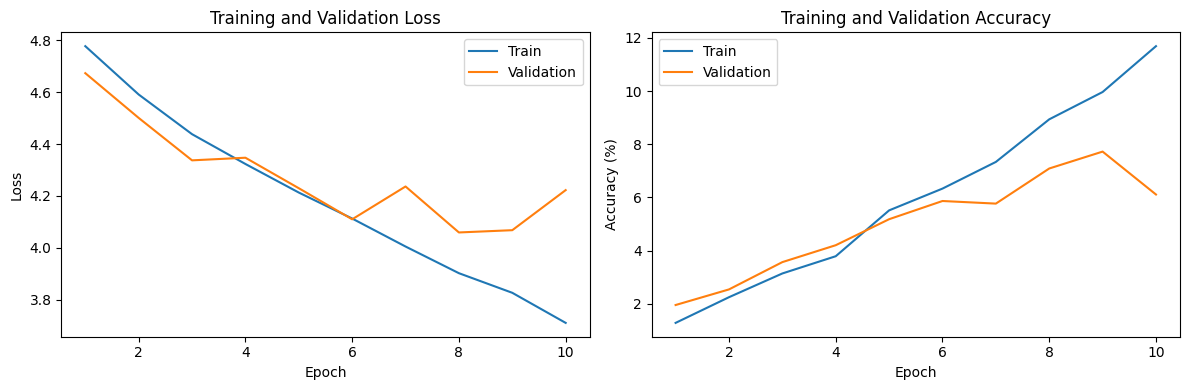

In [24]:
# Slightly overfitting, maybe can add learning rate scheduler or increase hidden units but that's enough for now.
Plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [28]:
# Train the resnet model
train_losses, train_accuracies, valid_losses, valid_accuracies = Train(resnet, save=True, epochs=10)

----------------------------------------------------
Epoch:1


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.15it/s]


Train Loss: 3.63 - Train Acc: 23.85% - Validation Loss: 1.58 - Validation Acc: 72.62%
----------------------------------------------------
Epoch:2


Validation ...: 100%|██████████| 64/64 [00:11<00:00,  5.48it/s]


Train Loss: 1.43 - Train Acc: 61.82% - Validation Loss: 0.77 - Validation Acc: 79.32%
----------------------------------------------------
Epoch:3


Validation ...: 100%|██████████| 64/64 [00:11<00:00,  5.42it/s]


Train Loss: 0.99 - Train Acc: 71.59% - Validation Loss: 0.68 - Validation Acc: 80.44%
----------------------------------------------------
Epoch:4


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.12it/s]


Train Loss: 0.86 - Train Acc: 74.48% - Validation Loss: 0.61 - Validation Acc: 81.71%
----------------------------------------------------
Epoch:5


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.16it/s]


Train Loss: 0.76 - Train Acc: 75.83% - Validation Loss: 0.58 - Validation Acc: 82.59%
----------------------------------------------------
Epoch:6


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.13it/s]


Train Loss: 0.69 - Train Acc: 78.81% - Validation Loss: 0.55 - Validation Acc: 82.35%
----------------------------------------------------
Epoch:7


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.14it/s]


Train Loss: 0.65 - Train Acc: 79.74% - Validation Loss: 0.53 - Validation Acc: 82.79%
----------------------------------------------------
Epoch:8


Validation ...: 100%|██████████| 64/64 [00:11<00:00,  5.44it/s]


Train Loss: 0.61 - Train Acc: 80.92% - Validation Loss: 0.53 - Validation Acc: 82.30%
----------------------------------------------------
Epoch:9


Validation ...: 100%|██████████| 64/64 [00:12<00:00,  5.22it/s]


Train Loss: 0.58 - Train Acc: 81.79% - Validation Loss: 0.53 - Validation Acc: 83.03%
----------------------------------------------------
Epoch:10


Validation ...: 100%|██████████| 64/64 [00:13<00:00,  4.78it/s]


Train Loss: 0.56 - Train Acc: 82.61% - Validation Loss: 0.52 - Validation Acc: 83.81%


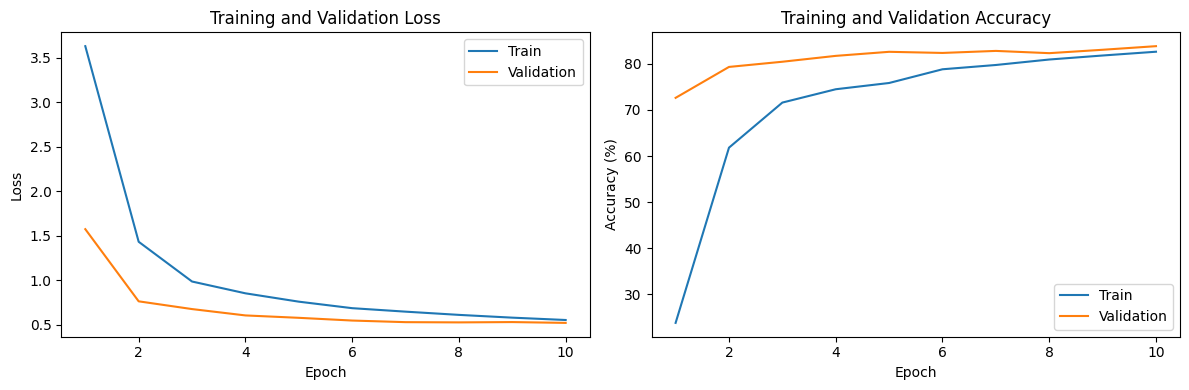

In [29]:
# Nearly perfect results, it's weird that validation accuracy is higher train accuracy.
# I didn't find any bug, i think it's about the distribution of unaugmented data.
Plot(train_losses, train_accuracies, valid_losses, valid_accuracies)

### 5. Making predictions
This section includes the predict function to use the model for prediction and evaluation of the model's performance.


---

In [30]:
# Libraries for making predictions
import requests
import numpy as np
import torch
import requests
from PIL import Image
from torchvision import transforms
import io

In [31]:
# For getting label name through data
label_mapping = {i: class_name for i, class_name in enumerate(full_dataset.classes)}

In [35]:
# Predict function takes image and model and returns label and probalilty score
def predict(model, image):
    model.eval()

    with torch.no_grad():
        image = image.unsqueeze(0) # batch dimension
        image = image.to(device)

        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

        # Convert predicted class index to label name using label_mapping
        predicted_label = label_mapping[predicted_class.item()]
        #predicted_label = label_mapping[predicted_class.item()]
        probability= probabilities[0][predicted_class].item()

    return predicted_label, round(probability, 2)

In [36]:
predict(resnet, valid_loader.dataset[123][0])

('beagle', 0.65)

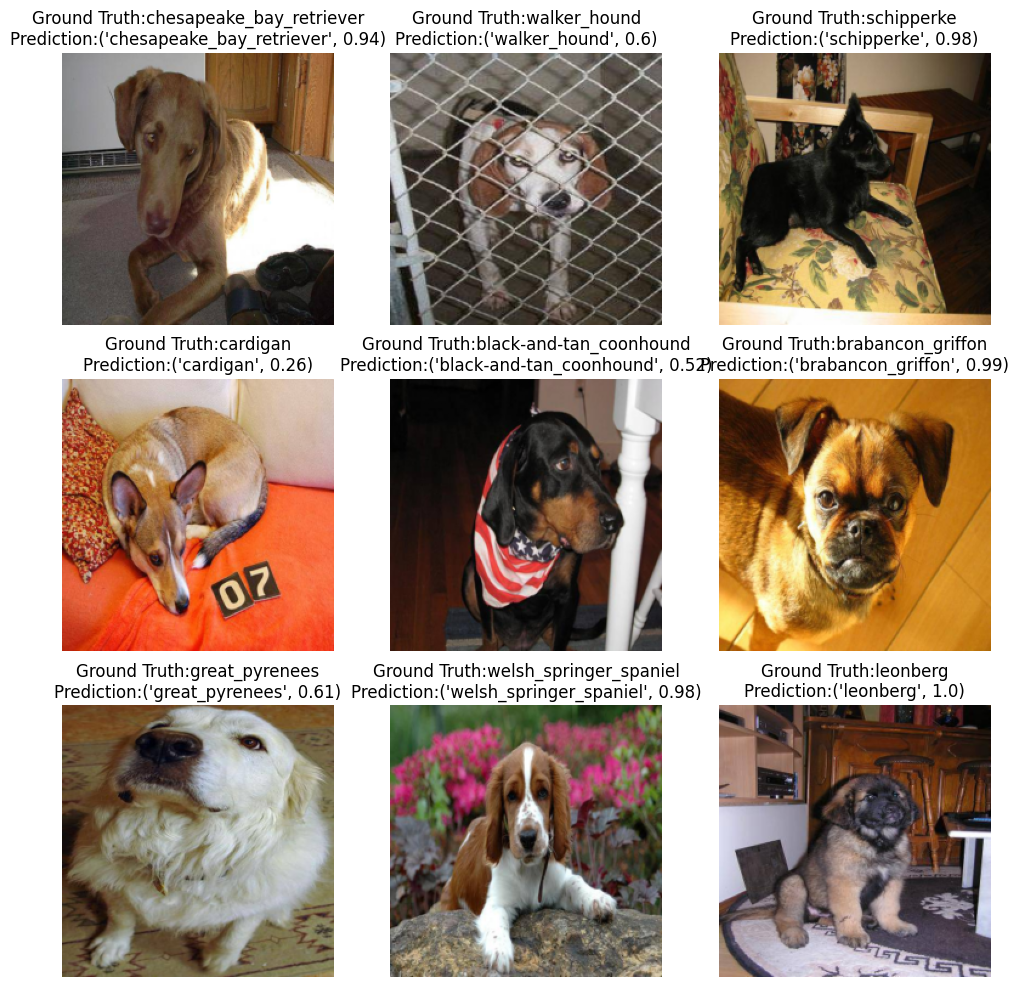

In [38]:
# Take a look for validation images to understand model's performance
def predict_random(model):
  random_numbers = [random.randint(0, 2045) for _ in range(9)]

  plt.figure(figsize=(12, 12))
  for i, n in enumerate(random_numbers):
    image = valid_loader.dataset[n][0]
    prediction = predict(model, image)
    ground_truth=valid_loader.dataset[n][1]
    ground_truth = label_mapping[ground_truth]
    image_array = image.numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_array.transpose(1, 2, 0))
    plt.title(f"Ground Truth:{ground_truth}\nPrediction:{prediction}") #?
    plt.axis('off')

  plt.show()

predict_random(resnet)

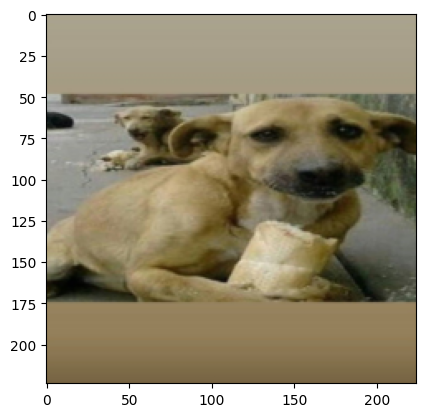

('american_staffordshire_terrier', 0.26)

In [42]:
# Making predictions from URL
url= "https://i.pinimg.com/736x/94/5f/ec/945fec0a86ec49c63aa38ce1748f8ee9.jpg"
response = requests.get(url)
image = Image.open(io.BytesIO(response.content))
image = image.convert('RGB')

# Transform the image
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
image = transform(image)

# Make predictions
image_array = image.numpy()
plt.imshow(image_array.transpose(1, 2, 0))
plt.show()
predict(resnet, image)

In [44]:
# Libraries for creating a confusion matrix
try:
    import torchmetrics, mlxtend
except:
    !pip install torchmetrics
    !pip install mlxtend
    import torchmetrics, mlxtend

In [45]:
# 1. Make predictions
preds = []
resnet.eval()
with torch.inference_mode():
  for image, label in valid_loader:
    image, label = image.to(device), label.to(device)
    # Do the forward pass
    logit = resnet(image)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    pred = torch.softmax(logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    preds.append(pred.cpu())
# Concatenate list of predictions into a tensor
pred_tensor = torch.cat(preds)

In [62]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

targets = torch.tensor([valid_dataset.dataset.targets[i] for i in valid_dataset.indices])
class_names = valid_dataset.dataset.classes

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=120, task='multiclass')
confmat_tensor = confmat(preds=pred_tensor,
                         target=targets)

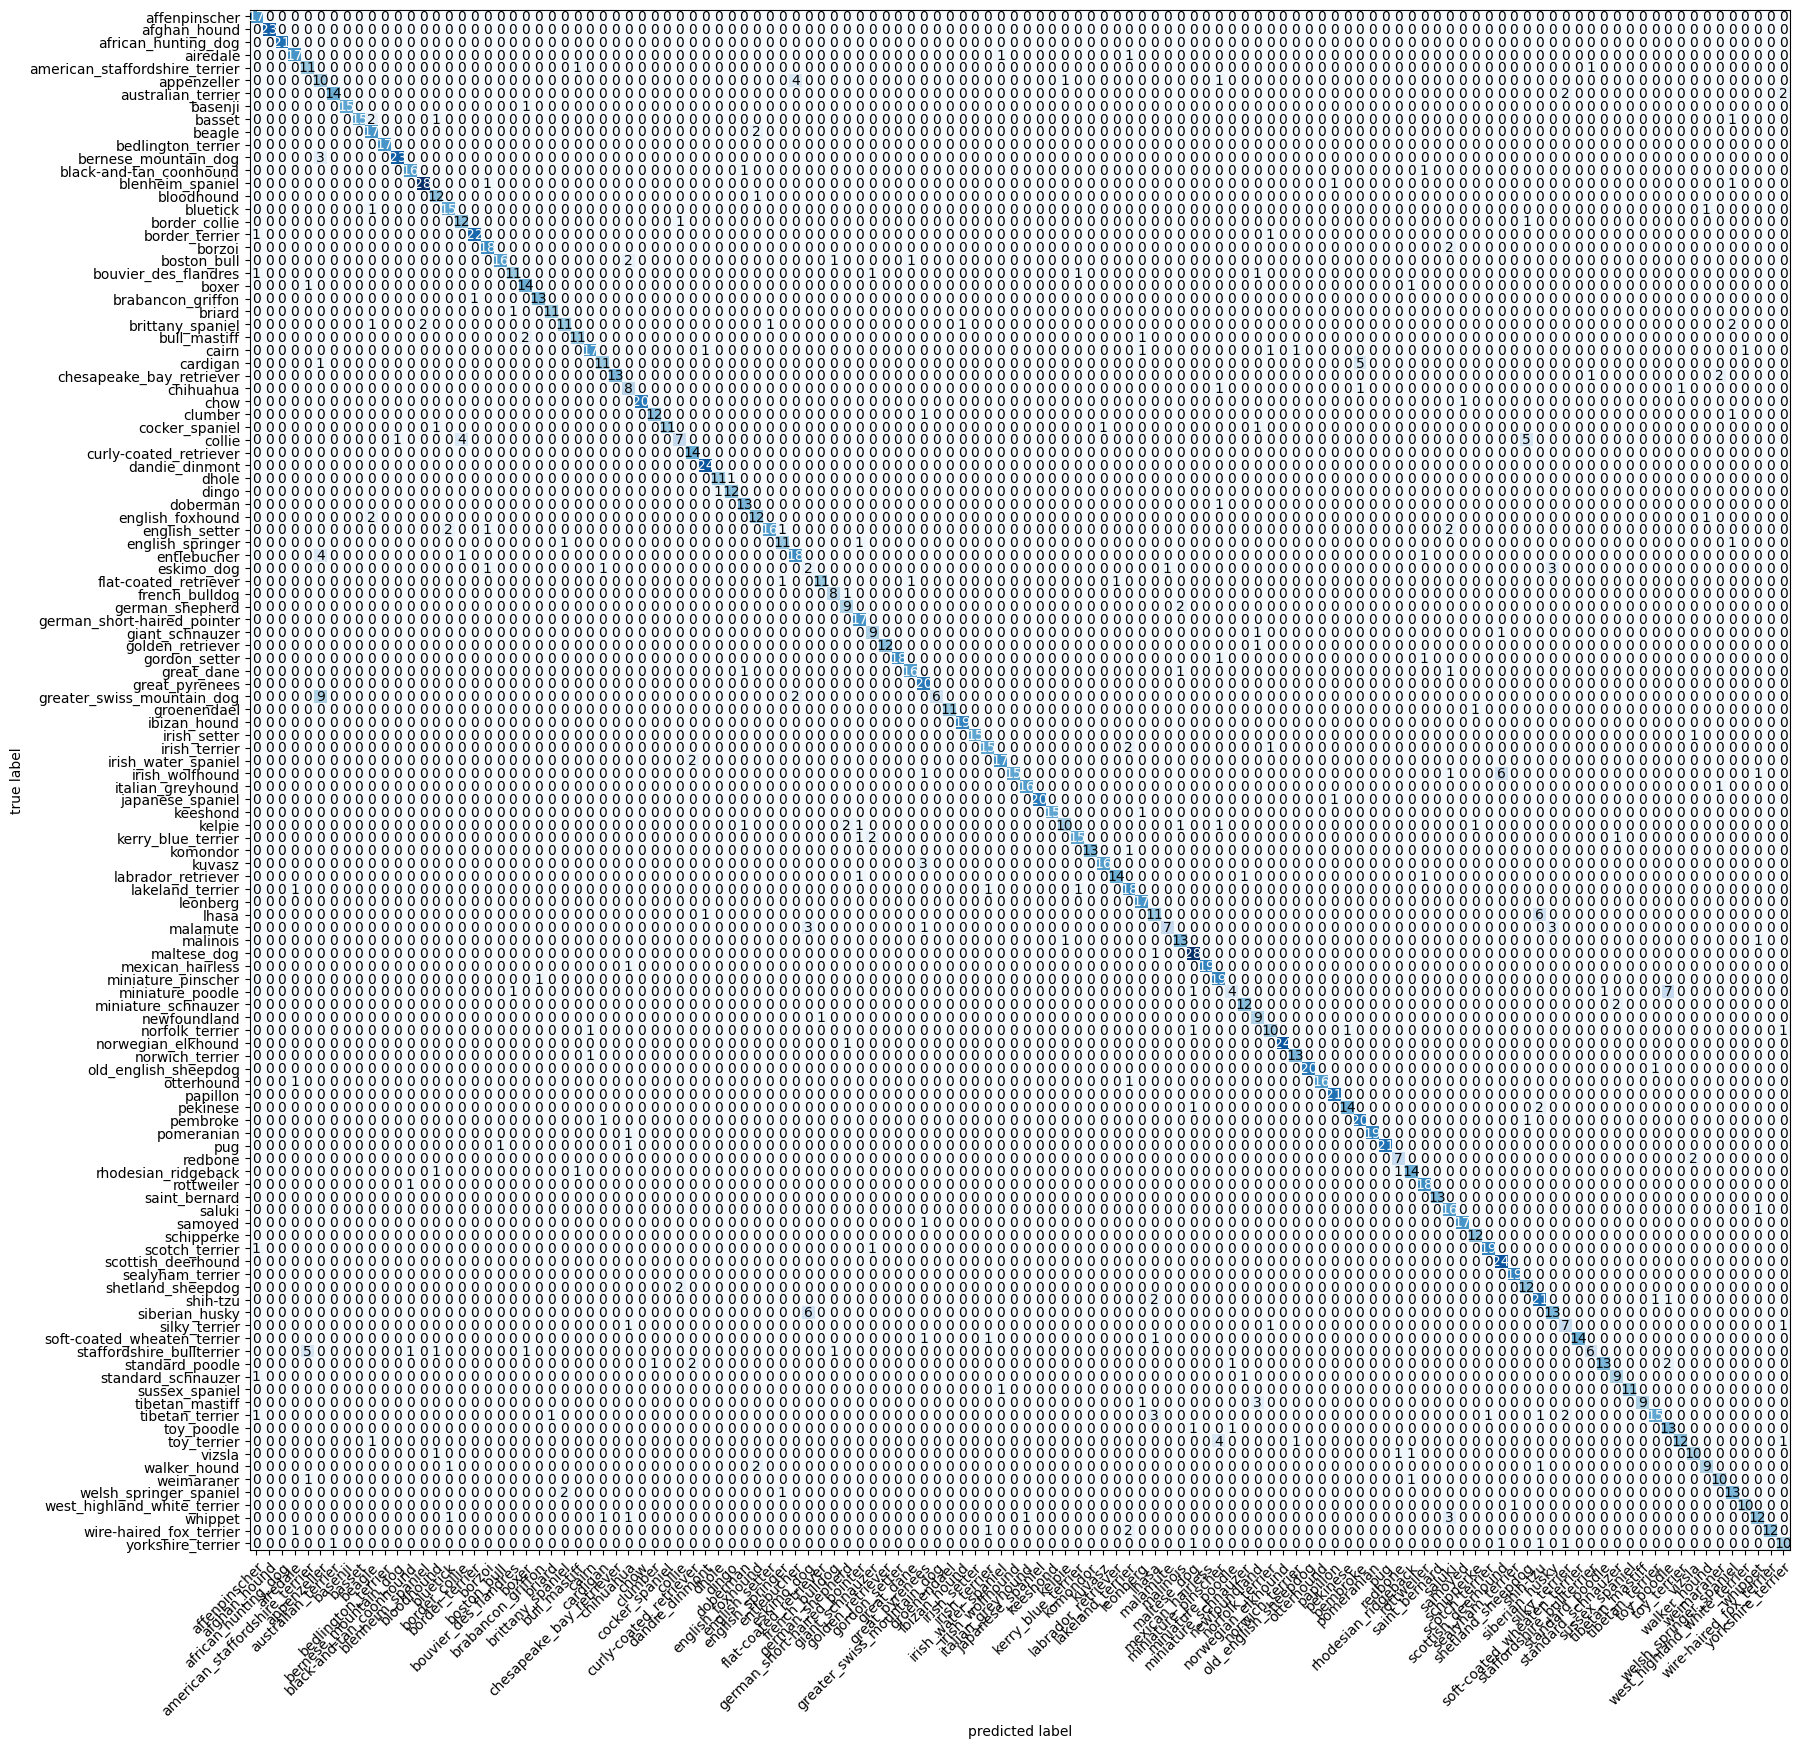

In [63]:
# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(60, 20))

### 6. Deployment

In [ ]:
# Saving the model as TorchScript for running in another environment
"""
# We've already save it with Train function before

model_scripted = torch.jit.script(resnet) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save
"""

In [57]:
# Saving label_mapping as json
import json
with open('label_mapping.json', 'w') as json_file:
    json.dump(label_mapping, json_file)

In [ ]:
# Creating utils.py file
"""
# utils.py
import torch
import json
from torchvision import transforms

with open('label_mapping.json', 'r') as json_file:
    label_mapping = json.load(json_file)

def load_model(path):
    model = torch.jit.load(path, map_location=torch.device("cpu"))
    return model

def predict(model, image):
    model.eval()

    # Transform the image
    transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

    image = transform(image)

    with torch.no_grad():
        image = image.unsqueeze(0)
        output = model(image)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)

        # Convert predicted class index to label name using label_mapping
        predicted_label = label_mapping[f"{predicted_class.item()}"]
        probability= probabilities[0][predicted_class].item()

    return predicted_label, round(probability, 2)
    """

In [ ]:
# Creating requirements.txt
"""
torchvision==0.16.1
torch==2.1.1
requests==2.31.0
streamlit==1.28.0
"""

In [ ]:
# Creating app.py with using streamlit
"""
# app.py
from utils import load_model, predict
import torch
import json
import requests
import io
from PIL import Image
import streamlit as st

st.title('Dog Breed Classification')

# set header
st.header('Please upload a image')

# upload file
file = st.file_uploader('', type=['jpeg', 'jpg', 'png'])
url = st.text_input("Or enter image URL:")
st.button("Load Image")

# load classifier
model = load_model('model_scripted.pt')

if file is not None:
    image = Image.open(file).convert('RGB')
    st.image(image, use_column_width=True)

    # classify image
    predicted, probability = predict(model, image)

    # write classification
    st.write("## {}".format(predicted))
    st.write("### Probability: {}%".format(int(probability * 100)))

if url != '':
    try:
        response = requests.get(url)
        image = Image.open(io.BytesIO(response.content)).convert('RGB')
        st.image(image, caption="Image from URL", use_column_width=True)

        # classify image
        predicted, probability = predict(model, image)

        # write classification
        st.write("## {}".format(predicted))
        st.write("### score: {}%".format(int(probability * 100)))

    except Exception as e:
        st.error(f"Error loading image from URL: {e}")
"""



---


**[Try it on Hugging Face Spaces](https://huggingface.co/spaces/egecandrsn/dog_breed_classification)**

---

